# Set-Up

In [0]:
# mount Google Drive to workspace
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
import cv2
import math
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

from tensorflow.python import keras
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer


RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
plt.rcParams["figure.facecolor"] = "w"


Using TensorFlow backend.


In [3]:
#@title Helper Functions

def get_class_label(val):
    """
    Function returns the key (Letter: a/b/c/...) value from the Alphaber dictionary
    based on its class index (1/2/3/...)
    """
    for key, value in alphabet.items():
        if value == val:
            return key
        

def load_data(dir, img_size=200):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    for path in tqdm(sorted(os.listdir(dir))):
        for file in os.listdir(dir + path):
            if not file.startswith('.'):
                img = cv2.imread(dir + path + '/' + file, 0)
                img = ~img
                img = cv2.GaussianBlur(img, (3, 3), 0)
                img = cv2.resize(
                    img,
                    dsize=(img_size, img_size),
                    interpolation=cv2.INTER_CUBIC
                )
                X.append(img)
                y.append(alphabet[path])

    X = np.array(X)
    X = X.astype('float32')/255.0
    y = np.array(y)
    print('\n{} images loaded.'.format(len(X)))
    return X, y


def load_original_imgs(dir, img_size=64):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    for file in tqdm(sorted(os.listdir(dir))):
        if not file.startswith('.'):
            img = cv2.imread(dir + '/' + file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(
                img,
                dsize=(img_size, img_size),
                interpolation=cv2.INTER_CUBIC
            )
            X.append(img)
            y.append(alphabet[file.replace('.jpg', '')])
    
    X = np.array(X)
    X = X.astype('float32')/255.0
    y = np.array(y)
    print('\n{} images loaded.'.format(len(X)))
    return X, y


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (15,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [0]:
# create alphabet dictionary to label the letters {'A':1, ..., 'nothing':29}
alphabet = {chr(i+96).upper():i for i in range(1,27)}
alphabet['space'] = 29
alphabet['del'] = 27
alphabet['nothing'] = 28

NUM_CLASSES = len(alphabet)

# Data Import and Preparation

In [0]:
!unzip 'gdrive/My Drive/Projects/asl/img_dataset/test.zip'
!unzip 'gdrive/My Drive/Projects/asl/img_dataset/train.zip'
!unzip 'gdrive/My Drive/Projects/asl/img_dataset/orig_sample.zip'
clear_output()

In [0]:
IMG_SIZE = 100

TEST_DIR = 'test/'
TRAIN_DIR = 'train/'
ORIG_DIR = 'orig_sample/'

X_train, y_train = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test = load_data(TEST_DIR, IMG_SIZE)
X_orig, y_orig = load_original_imgs(ORIG_DIR, IMG_SIZE)

  3%|▎         | 1/29 [00:00<00:03,  8.62it/s]


26661 images loaded.


100%|██████████| 29/29 [00:03<00:00,  9.10it/s]



6667 images loaded.


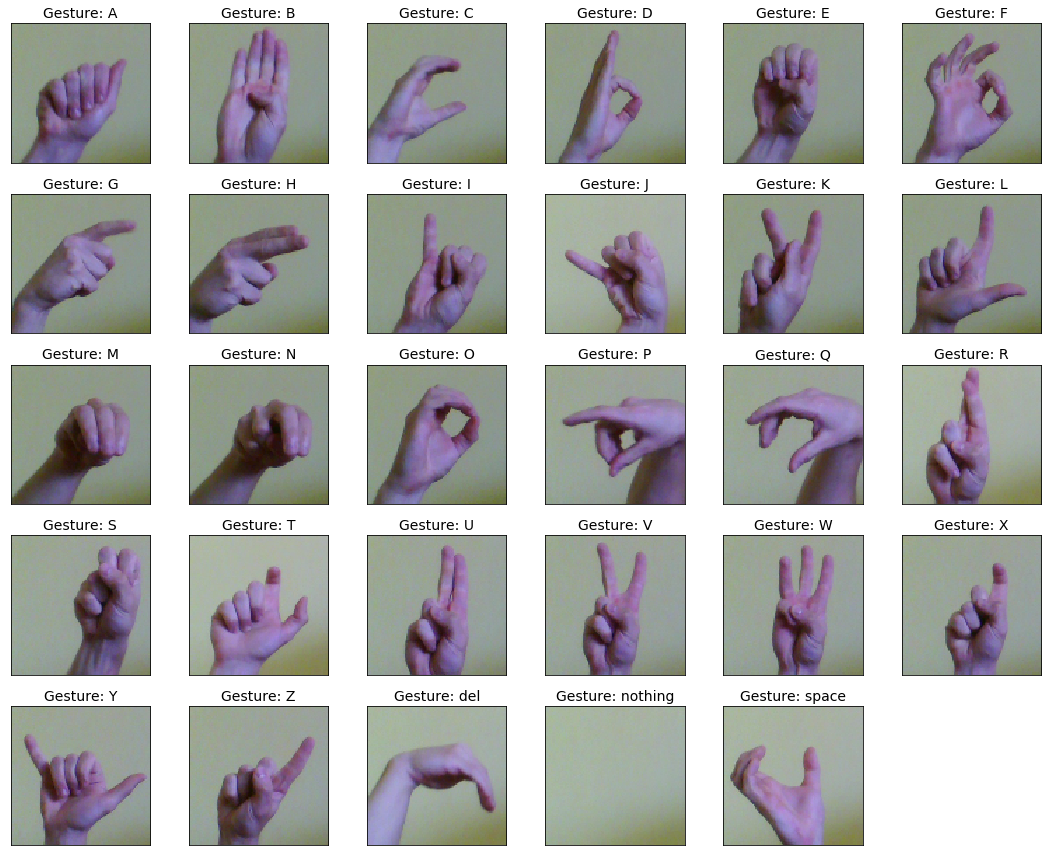

In [0]:
#@title Plot Gestures
unique_index = np.array([])
for i in range(NUM_CLASSES):
    i += 1
    unique_index = np.append(unique_index, np.argwhere(y_orig == i)[0][0])
unique_index = np.array([int(x) for x in unique_index])

plot_grid_size = int(math.sqrt(len(unique_index))) + 1
plt.figure(figsize=(15,12))
for i in range(len(unique_index)):
    img = X_orig[unique_index[i]]
    
    plt.subplot(5,plot_grid_size,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    letter = get_class_label(y_orig[unique_index[i]])
    plt.title('Gesture: {}'.format(letter), fontsize=14)
plt.tight_layout()
plt.savefig('orig_imgs.jpg')
plt.show()

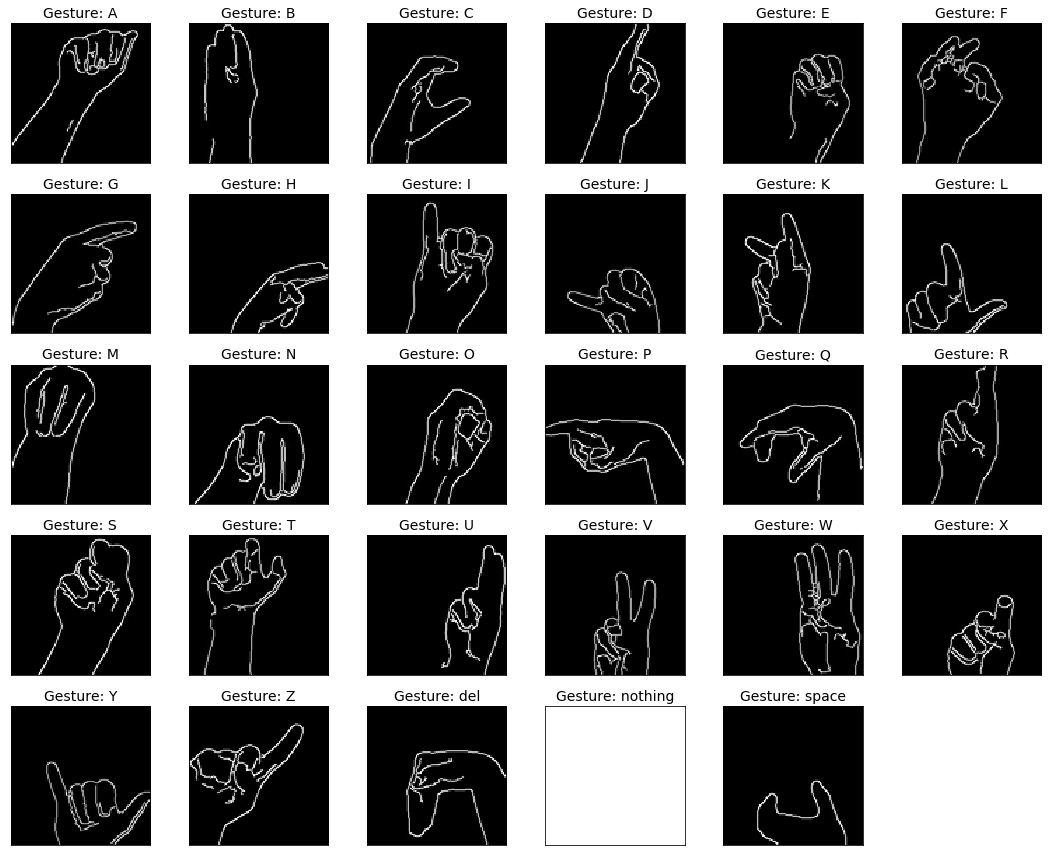

In [0]:
#@title Plot Model Images
unique_index = np.array([])
for i in range(NUM_CLASSES):
    i += 1
    unique_index = np.append(unique_index, np.argwhere(y_train == i)[0][0])
unique_index = np.array([int(x) for x in unique_index])

plot_grid_size = int(math.sqrt(len(unique_index))) + 1
plt.figure(figsize=(15,12))
for i in range(len(unique_index)):
    img = X_train[unique_index[i]]
    
    plt.subplot(5,plot_grid_size,i+1)
    plt.imshow(img, cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    letter = get_class_label(y_train[unique_index[i]])
    plt.title('Gesture: {}'.format(letter), fontsize=14)
plt.tight_layout()
plt.savefig('model_imgs.jpg')
plt.show()

In [0]:
#@title Plot side to side
# left = cv2.imread('orig_imgs.jpg')
# right = cv2.imread('model_imgs.jpg')

# plt.figure(figsize=(17,20))
# plt.subplot(121)
# plt.imshow(left)
# plt.xticks([])
# plt.yticks([])
# plt.tight_layout()
# plt.subplot(122)
# plt.imshow(right)
# plt.xticks([])
# plt.yticks([])
# plt.tight_layout()
# plt.savefig('sidetoside.jpg')
# plt.show()

In [0]:
# transform
X_train = X_train.reshape(X_train.shape + (1,))
X_test = X_test.reshape(X_test.shape + (1,))

label_binarizer = LabelBinarizer()
y_train_encoded = label_binarizer.fit_transform(y_train)
y_test_encoded = label_binarizer.fit_transform(y_test)

# CNN from Scratch

In [0]:
img_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))

x = layers.Conv2D(64, 3, activation='relu')(img_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Conv2D(128, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Dropout(0.5)(x)
x = layers.Conv2D(64, 2, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

output = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(img_input, output)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-04),
    metrics=['acc']
)

In [0]:
EPOCHS = 20
BATCH_SIZE = 64

history = model.fit(
    x=X_train, 
    y=y_train_encoded,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test_encoded)
)

Instructions for updating:
Use tf.cast instead.
Train on 26661 samples, validate on 6667 samples
Epoch 1/20
26661/26661 [==============================] - 35s 1ms/step - loss: 3.3440 - acc: 0.0493 - val_loss: 3.0173 - val_acc: 0.2388
Epoch 2/20
26661/26661 [==============================] - 29s 1ms/step - loss: 2.4345 - acc: 0.3264 - val_loss: 1.5999 - val_acc: 0.6309
Epoch 3/20
26661/26661 [==============================] - 30s 1ms/step - loss: 1.7563 - acc: 0.4767 - val_loss: 0.9921 - val_acc: 0.7696
Epoch 4/20
26661/26661 [==============================] - 30s 1ms/step - loss: 1.3512 - acc: 0.5829 - val_loss: 0.5950 - val_acc: 0.8613
Epoch 5/20
26661/26661 [==============================] - 30s 1ms/step - loss: 1.0694 - acc: 0.6562 - val_loss: 0.4866 - val_acc: 0.8877
Epoch 6/20
26661/26661 [==============================] - 30s 1ms/step - loss: 0.8726 - acc: 0.7131 - val_loss: 0.2865 - val_acc: 0.9334
Epoch 7/20
26661/26661 [==============================] - 30s 1ms/step - loss: 0.

## Model Performance

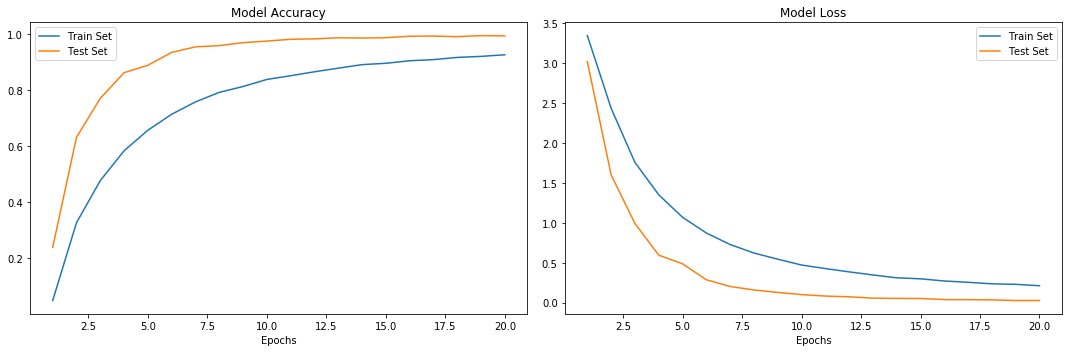

In [0]:
#@title Plot Model Performance
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Test Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.title('Model Loss')

plt.tight_layout()
plt.savefig('model_performance.jpg')
plt.show()

In [0]:
# validate
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1) + 1

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

Test Accuracy = 0.99


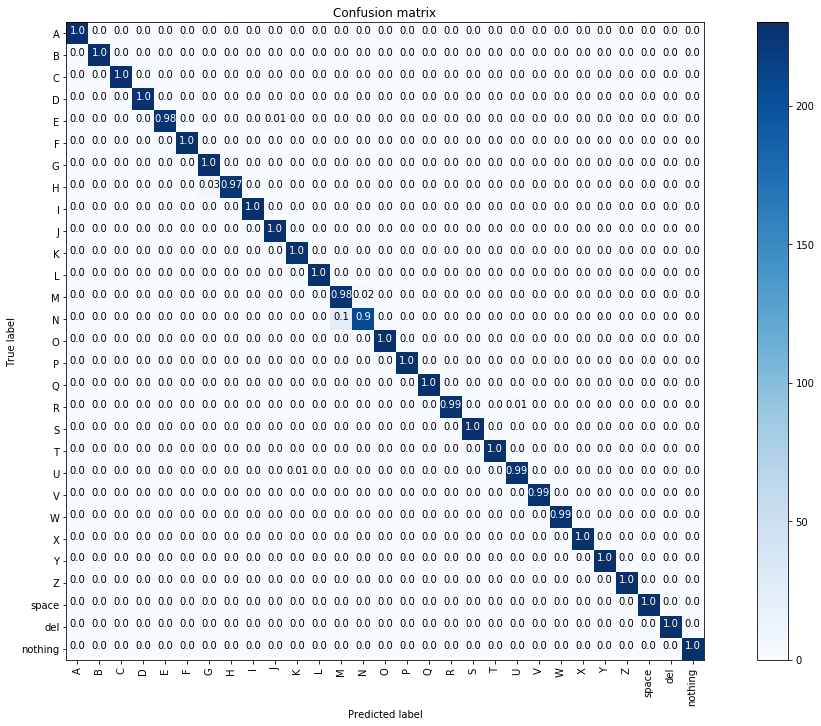

In [0]:
confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(alphabet.keys()), normalize=True)

In [0]:
model.save('model_edged.h5')